# Exploration and a Simple Baseline

In this part of the assignment, we'll introduce the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST) dataset, and train a Naive Bayes model as a simple baseline. The SST, introduced by [(Socher et al. 2013)](http://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf) consists of approximately 10,000 sentences from movie reviews associated with fine-grained sentiment labels on a five-point scale, and is a popular benchmark for text classification.

## Outline

- **Part (a):** The Stanford Sentiment Treebank
- **Part (b):** Naive Bayes
- **Part (c):** Exploring Negation

Exercises are interspersed throughout the notebook. Be sure you catch all of them! There are 4 questions for Part (a), 2 for Part (b), and 3 for Part (c). Some questions have multiple parts.

In [8]:
# Install a few python packages using pip
from w266_common import utils
utils.require_package("wget")      # for fetching dataset
utils.require_package("bokeh")     # for plotting histograms
utils.require_package("graphviz")  # for rendering trees

### Preliminaries: GraphViz

This notebook uses [GraphViz](https://www.graphviz.org/) to render tree structures. On Ubuntu / Debian (including Google Cloud), you can install it by running on the command line:
```
sudo apt-get install graphviz
```

For Mac OSX, you can install using Homebrew:
```
brew install graphviz
```
or see https://www.graphviz.org/download/ for more options. Run the cell below to set up rendering and show a sample tree.

Overriding nltk.tree.Tree pretty-printing to use custom GraphViz.
Sample tree to test rendering:


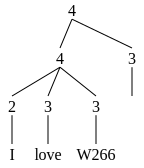

In [2]:
import nltk
from w266_common import treeviz
import sst
# Monkey-patch NLTK with better Tree display that works on Cloud or other display-less server.
print("Overriding nltk.tree.Tree pretty-printing to use custom GraphViz.")
treeviz.monkey_patch(nltk.tree.Tree, node_style_fn=sst.sst_node_style, format='svg')

# Test rendering
print("Sample tree to test rendering:")
nltk.tree.Tree.fromstring("(4 (4 (2 I) (3 love) (3 W266)) (3 😄))")

In [3]:
from __future__ import division
import os, sys, re, json, time, datetime, shutil
import itertools, collections
from importlib import reload
from IPython.display import display, HTML

# NLTK, NumPy, and Pandas.
import nltk
import numpy as np
import pandas as pd

# Helper libraries.
from w266_common import utils, vocabulary, tf_embed_viz, treeviz
from w266_common import patched_numpy_io
# Code for this assignment
import sst

# Bokeh for plotting.
import bokeh.plotting as bp
from bokeh.models import HoverTool
bp.output_notebook()

# Helper code for plotting histograms
def plot_length_histogram(lengths, x_range=[0,100], bins=40, normed=True):
    hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    bin_widths =  (bin_edges[1:] - bin_edges[:-1])

    hover = HoverTool(tooltips=[("bucket", "@x"), ("count", "@top")], mode="vline")
    fig = bp.figure(plot_width=800, plot_height=400, tools=[hover])
    fig.vbar(x=bin_centers, width=bin_widths, top=hist, hover_fill_color="firebrick")
    fig.y_range.start = 0
    fig.x_range.start = 0
    fig.xaxis.axis_label = "Example length (number of tokens)"
    fig.yaxis.axis_label = "Frequency"
    bp.show(fig)

Loading BokehJS ...

# Part (a): The Stanford Sentiment Treebank

_If you haven't yet, be sure to familiarize yourself with the [Prelude notebook](Prelude.ipynb), as this assignment will assume familiarity with the text pre-processing steps described there._

The [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/index.html) (SST) is one of the most widely used datasets as a benchmark for text classification. It consists of 11,855 sentences drawn from a corpus of movie reviews (originally from Rotten Tomatoes), each labeled with sentiment on a five-point scale.

For example:
```
sentence: [A warm , funny , engaging film .]
label:    4 (very positive)
```

For this assignment, we'll work with the binarized form of the dataset, where the lowest two classes are mapped to a single "negative" label, the highest two are mapped to a single "positive" label, and neutral examples are omitted.

**Side note:**
Unlike most classification datasets, SST is also a _treebank_, which means each sentence is associated with a tree structure that decomposes it into subphrases. So for the example above, we'd also have sentiment labels for `[warm , funny]` and `[engaging film .]` and so on. The trees are created by running the [Stanford Parser](https://nlp.stanford.edu/software/lex-parser.shtml) over the original sentences, then crowdsourcing sentiment labels on each sub-phrase. We'll talk more about treebanks later in the course, and in Assignment 5 you'll implement a simple version of the Stanford Parser.

For the purposes of this assignment, we'll mostly concern ourselves with the sentence-level ("root") labels, but the tree structure will come in handy in two places:
- As a way of analyzing the examples to find instances of negation
- (optionally) As a source of additional training data, by including phrase labels

### Obtaining the Data
The data is distributed as serialized trees in [S-expression](https://en.wikipedia.org/wiki/S-expression) form, like this:
```
(4 (4 (2 A) (4 (3 (3 warm) (2 ,)) (3 funny))) (3 (2 ,) (3 (4 (4 engaging) (2 film)) (2 .))))
```

We've provided an `SSTDataset` class (in `sst.py`) which will download the dataset and parse the S-expressions into [`nltk.tree.Tree`](http://www.nltk.org/api/nltk.html?highlight=tree#nltk.tree.Tree) objects that you can easily view in the notebook.

`SSTDataset` also implements the text-processing pipeline described in the [Prelude notebook](Prelude.ipynb), and provides methods (`as_sparse_bow` and `as_padded_array`) to convert the data to matrix form.

Run the cell below; it will download a ~6MB .zip file to the local directory the first time you run it.

In [4]:
import sst
ds = sst.SSTDataset(V=20000).process(label_scheme="binary")

Loading SST from data/sst/trainDevTestTrees_PTB.zip
Training set:     8,544 trees
Development set:  1,101 trees
Test set:         2,210 trees
Building vocabulary - 16,474 words
Processing to phrases...  Done!
Splits: train / dev / test : 98,794 / 13,142 / 26,052


A few members of the `SSTDataset()` class that you might find useful (click through and skim read):
- **`ds.vocab`**: a [`vocabulary.Vocabulary`](https://github.com/datasci-w266/2022-spring-main/blob/master/common/vocabulary.py#L8) object managing the model vocabulary
- **`ds.{train,dev,test}_trees`**: a list of [`nltk.tree.Tree`](http://www.nltk.org/api/nltk.html?highlight=tree#nltk.tree.Tree) objects representing each sentence
- **`ds.{train,dev,test}`**: a Pandas DataFrame containing the _processed_ examples, including all subphrases. `label` is the target label, `is_root` denotes whether this example is a root node (full sentence), and `root_id` is the index of the tree that the example was derived from.

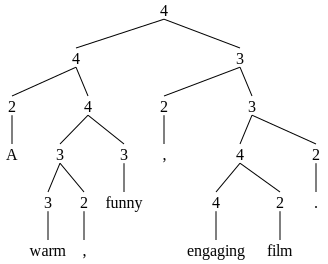

In [10]:
# Look at a tree for a positive review
ds.dev_trees[3]

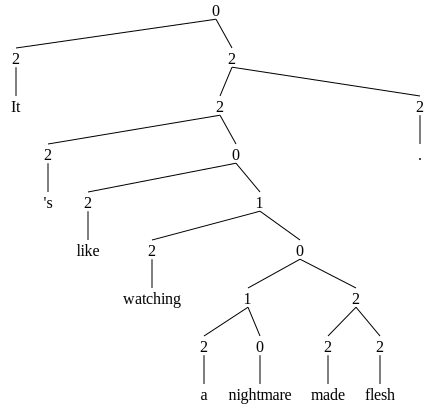

In [6]:
# Look at a tree for a negative review
ds.dev_trees[361]

In [7]:
# Labels.
ds.train.label[0:10]

0     1
4     1
5     1
7     1
25    1
31    1
33    1
35    1
37    1
39    1
Name: label, dtype: int64

## Part (a) questions: Exploring the Data

Let's explore the data a bit, to get a sense of what we're working with. If you're not familiar with DataFrames, you may wish to review the Pandas documentation: https://pandas.pydata.org/pandas-docs/stable/dsintro.html 

Answer the following questions in the cells below:

1. Looking at only the root examples in the training set (*Hint: use `ds.train[ds.train.is_root]`*), what is the fraction of positive labels? Is the classification task balanced, or close to it? If we used most-common-class as a baseline classifier, what would the accuracy be?
2. What are the five most common tokens (excluding punctuation) in the entire dataset? (*Hint: there are several ways to get at this - you might use `collections.Counter`, or poke around in the `ds.vocab` object.*)
3. Use the `plot_length_histogram` function (defined above) to plot a histogram of the sentence lengths in the training set. What is the 95% percentile length? (i.e. 95% of examples in the training set should be shorter than this)
4. Repeat 3., but this time including all subphrases. Notice the difference in distributions. Think about how predicting subphrases might be problematic if they're too short.

Use the cells below for your code solutions. Each part shouldn't require more than a couple lines, but you're welcome to explore more!

In [77]:
#### YOUR CODE HERE ####
# Code for Part (a).1

train_root = ds.train[ds.train.is_root]
frac_pos = train_root.label.sum() / train_root.size
print(f"Positive labels fraction is {frac_pos:.5f}. \
It is not balanced. \
If most common class used as baseline classifer, the accuracy is {1 - frac_pos:.5f}")

#### END(YOUR CODE) ####

Positive labels fraction is 0.10434. It is not balanced. If most common class used as baseline classifer, the accuracy is 0.89566


In [65]:
#### YOUR CODE HERE ####
# Code for Part (a).2

# find root sentences
dev_root = ds.dev[ds.dev.is_root]
test_root = ds.test[ds.test.is_root]
# concatenate train, dev and test and flatten the iterable sequence
all_tokens = pd.concat([train_root, dev_root, test_root], ignore_index=True).tokens.explode()
# use Counter to count words
top_5_words = [w[0] for w in collections.Counter(all_tokens).most_common(20) if w[0] not in [".", ",", "!", ";"]][:5]
print(f"Most common 5 words are {top_5_words}.")

#### END(YOUR CODE) ####

Most common 5 words are ['the', 'a', 'and', 'of', 'to'].


In [80]:
#### YOUR CODE HERE ####
# Code for Part (a).3

train_sent_len = train_root.tokens.map(len)
plot_length_histogram(train_sent_len)
print(f"95% percentile is {np.percentile(train_sent_len, 95)}.")

#### END(YOUR CODE) ####

/var/folders/dp/f69vs__d2xl1hb9zdnxjh2k80000gn/T/ipykernel_3090/2146898695.py:25: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)


95% percentile is 36.0.


In [86]:
#### YOUR CODE HERE ####
# Code for Part (a).4

train_sub = ds.train.tokens.map(len)

plot_length_histogram(train_sub)
print(f"95% percentile including subphrase is {np.percentile(train_sub, 95)}.")
print(f"If sentence is too short, the problem will be ...????")


#### END(YOUR CODE) ####

/var/folders/dp/f69vs__d2xl1hb9zdnxjh2k80000gn/T/ipykernel_3090/2146898695.py:25: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bin_edges = np.histogram(a=lengths, bins=bins, normed=normed, range=x_range)


95% percentile including subphrase is 24.0.
If sentence is too short, the problem will be ...????


# Part (b): Naive Bayes

In this section, we'll build and explore a Naive Bayes model as a baseline classifier for our dataset.

Naive Bayes is perhaps the simplest possible classification algorithm, but it's one that still surprisingly effective for many text classification problems. Recall from your Machine Learning course:

$$ P(y = k) = \hat{\theta}_k = \frac{1}{N}\sum_{i = 1}^N \mathbf{1}[y_i = k] $$

$$ P(x_j | y = 1) = \hat{\theta}_{k,j} = 
\frac{ 
\sum_{i = 1}^N  \sum_{j' = 1}^{n_i} \mathbf{1}[y_i = 1 \wedge x_{j'} = j]
}{
\sum_{i = 1}^N  \mathbf{1}[y_i = 1] \cdot n_i
}
$$

where $N$ is the size of the dataset, and $n_i$ is the length (number of tokens of the $i^{th}$ example. Prediction is done by computing the score:

$$ \mathrm{score}(x) = \log \left(\frac{P(y = 1) \prod_{j=1}^n P(x_j | y = 1)}{P(y = 0) \prod_{j=1}^n P(x_j | y = 0)}\right) $$

We'll just use the [implementation from scikit-learn](http://scikit-learn.org/stable/modules/naive_bayes.html). Like other scikit-learn classifiers, this expects the input as a `scipy.sparse` matrix. Run the cell below:

In [87]:
# 'csr' stands for "Compressed Sparse Row", which is one format
# for representing sparse matricies.
train_x_csr, train_y = ds.as_sparse_bow("train", root_only=True)
test_x_csr,  test_y  = ds.as_sparse_bow("test", root_only=True)
print("Training set: x = {:s} sparse, y = {:s}".format(str(train_x_csr.shape), 
                                                str(train_y.shape)))
print("Test set:     x = {:s} sparse, y = {:s}".format(str(test_x_csr.shape), 
                                                str(test_y.shape)))

Training set: x = (6920, 16474) sparse, y = (6920,)
Test set:     x = (1821, 16474) sparse, y = (1821,)


Note the `root_only=True` parameter - this will return only examples corresponding to whole sentences. If you set this to false, you can get examples for all phrases.

## Part (b) Questions

Answer the following questions in the **answer file found in this directory** and code cells below.

**Question 1.)** Implement Naive Bayes using `sklearn.naive_bayes.MultinomialNB`. Train on the training set and evaluate accuracy on the test set using `.predict(...)`. 

Your model should train almost instantly, and score between 82% and 83% - not bad! On SST, this is actually a very strong baseline.

Recall that Naive Bayes can be interpreted as a linear model, where score is given by:

$$ \mathrm{score}(x) = \log \left(\frac{P(y = 1) \prod_{j=1}^n P(x_j | y = 1)}{P(y = 0) \prod_{j=1}^n P(x_j | y = 0)}\right) 
= \left( \log\hat{\theta}_1 - \log\hat{\theta}_0 \right) + \sum_{j=1}^n \left( \log\hat{\theta}_{1,j} - \log\hat{\theta}_{0,j} \right)$$

You can access the values $\log\hat{\theta}_{k,j}$ from the trained model using `nb.feature_log_prob_[k,j]`.

**Question 2.)** In the cell below, compute the weights $w_j = \left( \log\hat{\theta}_{1,j} - \log\hat{\theta}_{0,j} \right)$ of the linear model, and find the top 10 most negative and most positive weights. _(Hint: use `np.argsort` to get the indices of the most extreme elements.)_ Put the most negative and most positive word in the answers file.  Do the features you found make sense for this domain?

In [140]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
#### YOUR CODE HERE ####
# Code for part (b).1

nb = MultinomialNB()
nb.fit(train_x_csr, train_y)
y_pred = nb.predict(test_x_csr)

#### END(YOUR CODE) ####
acc = accuracy_score(test_y, y_pred)
print("Accuracy on test set: {:.02%}".format(acc))

Accuracy on test set: 82.21%


In [141]:
#### YOUR CODE HERE ####
# Code for part (b).2

linear_weights = np.squeeze(np.diff(nb.feature_log_prob_, axis=0)) # populate this with actual values
top_negative_features = np.argsort(nb.feature_log_prob_[0])[::-1][:5]
top_positive_features = np.argsort(nb.feature_log_prob_[1])[::-1][:5]

#### END(YOUR CODE) ####

print("Most negative features:")
for idx in top_negative_features:
    print("  {:s} ({:.02f})".format(ds.vocab.id_to_word[idx], 
                                    linear_weights[idx]))
print("")
print("Most positive features:")
for idx in top_positive_features:
    print("  {:s} ({:.02f})".format(ds.vocab.id_to_word[idx], 
                                    linear_weights[idx]))

Most negative features:
  . (0.02)
  the (0.04)
  , (0.16)
  a (0.11)
  of (0.16)

Most positive features:
  . (0.02)
  , (0.16)
  the (0.04)
  a (0.11)
  and (0.32)


# Part (c): Examining Negation

While Naive Bayes performs well in the aggregate, as a linear model it's still limited in its ability to model complex phenomena in the data. Each feature - in this case, each word - contributes a weight to the total, and if the sum is $\ge 0$ we predict the example is positive. But what happens when we have an example with both positive and negative words? For instance:

```
[Brando 's performance fell short of the high standards set by his earlier work .]
[A thoughtful look at a painful incident that made headlines in 1995 .]
```

Run the cell below to evaluate your model on these examples. It should predict both as positive.

In [142]:
examples = ["Brando 's performance fell short of the high standards set by his earlier work .",
            "A thoughtful look at a painful incident that made headlines in 1995 ."]
canonicalized_examples = [ds.canonicalize(s.split()) for s in examples]
id_lists = [ds.vocab.words_to_ids(s) for s in canonicalized_examples]
x = utils.id_lists_to_sparse_bow(id_lists, ds.vocab.size)
nb.predict(x)

array([1, 1], dtype=int32)

## Part (c).1
<a id="answers_c1"></a>

**Question 1.)** Why does the model get the first example wrong?  Think about what other kinds of sentence structure might fail to be properly understood by a linear model.  *Hint: See the next cell.

In [143]:
[x for x in zip(canonicalized_examples[0], linear_weights[np.array(id_lists[0])])]

[('<unk>', -0.07947581123340974),
 ("'s", 0.032134724769587564),
 ('performance', 1.0991791851082366),
 ('fell', -0.7726229917933551),
 ('short', -0.5213085635124504),
 ('of', 0.1577996227186711),
 ('the', 0.035492833505731625),
 ('high', -0.07947581123341152),
 ('standards', 0.6136713693265357),
 ('set', -0.18483632689123652),
 ('by', -0.03560912912782843),
 ('his', 0.15123398046411562),
 ('earlier', -0.995766543107564),
 ('work', 0.4801399767020129),
 ('.', 0.0184617237532958)]

It's always important to look at individual examples, but let's try to do this a bit more systematically. Recall that SST gives us labels not only at the whole-sentence (root) level, but for individual phrases as well. We can use this to look for examples where polarity changes between different parts of the sentence. Here's one of the examples above:

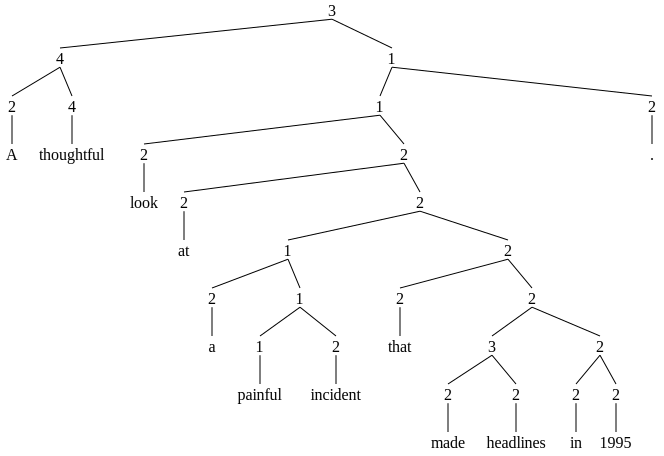

In [150]:
ds.test_trees[210]

The following cell will comb through the test set, looking for examples where there's some degree of ambiguity. We'll use a fairly crude heuristic for now: count up all the non-neutral phrases for a given sentence, and look at ones where there's a mix of both positive and negative labels.

In [151]:
df = ds.test

gb = df.groupby(by=['root_id'])
interesting_ids = []   # root ids, index into ds.test_trees
interesting_idxs = []  # DataFrame indices, index into ds.test
# This groups the DataFrame by sentence
for root_id, idxs in gb.groups.items():
    # Get the average score of all the phrases for this sentence
    mean = df.loc[idxs].label.mean()
    if (mean > 0.4 and mean < 0.6):
        interesting_ids.append(root_id)
        interesting_idxs.extend(idxs)
        
print("Found {:,} interesting examples".format(len(interesting_ids)))
# This will extract only the "interesting" sentences we found above
test_x_interesting, test_y_interesting = ds.as_sparse_bow("test", root_only=True, 
                                                          df_idxs=interesting_idxs)
print("Interesting ids (into ds.test_trees): ", interesting_ids)

Found 246 interesting examples
Interesting ids (into ds.test_trees):  [0, 27, 31, 32, 75, 80, 90, 96, 117, 124, 138, 140, 141, 160, 166, 186, 187, 205, 210, 212, 227, 232, 254, 269, 271, 285, 296, 307, 312, 327, 335, 373, 397, 399, 406, 407, 410, 426, 447, 511, 512, 516, 521, 534, 539, 563, 577, 588, 606, 610, 611, 637, 640, 645, 655, 662, 664, 713, 720, 721, 724, 739, 755, 758, 763, 776, 791, 793, 796, 802, 805, 810, 818, 840, 858, 887, 898, 899, 909, 910, 912, 929, 930, 961, 970, 973, 974, 975, 979, 1008, 1032, 1036, 1066, 1067, 1076, 1098, 1101, 1108, 1114, 1131, 1138, 1142, 1159, 1183, 1185, 1189, 1193, 1198, 1206, 1214, 1215, 1235, 1241, 1243, 1244, 1261, 1267, 1273, 1275, 1279, 1280, 1293, 1296, 1302, 1303, 1312, 1318, 1319, 1321, 1322, 1324, 1326, 1328, 1338, 1341, 1346, 1359, 1363, 1371, 1383, 1398, 1402, 1413, 1443, 1452, 1456, 1458, 1462, 1464, 1480, 1481, 1486, 1487, 1488, 1507, 1509, 1513, 1516, 1527, 1537, 1552, 1576, 1582, 1587, 1594, 1597, 1602, 1607, 1608, 1615, 1619, 1

## Part (c) continued

Answer the following in the cells below.

**Question 2.)** Examine a few of the "interesting" trees. What kinds of patterns do you see? What is the relation of the polarity of the sub-phrases to that of the whole sentence? Is this well-captured by a linear model?

**Question 3.)** Evaluate your model on `test_x_interesting` and compute accuracy. Does your model do better or worse on this slice of the data than on the whole test set (interesting + uninteresting examples)? What is the _relative_ change in the error rate? _(For example, if you go from 90% accuracy to 85%, that's a 50% increase in error!)_

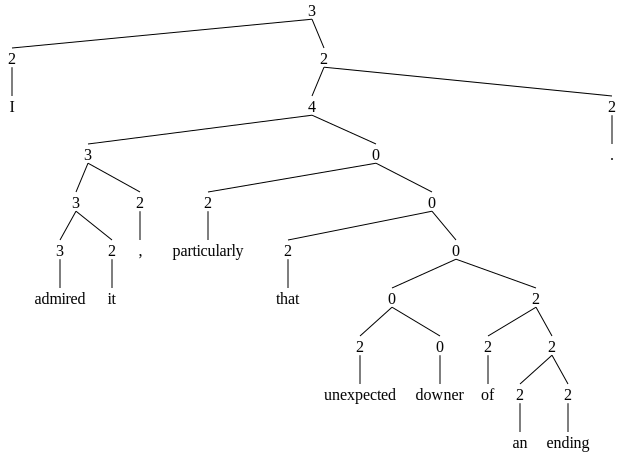

In [214]:
#### YOUR CODE HERE ####
# Code for part (c).2
# Example: display(ds.test_trees[idx])

test_id = 21

display(ds.test_trees[interesting_ids[test_id]])

#### END(YOUR CODE) ####

In [212]:
ds.test.label[interesting_ids[test_id]]

1

In [215]:
#### YOUR CODE HERE ####
# Code for part (c).3

acc = accuracy_score(test_y_interesting, nb.predict(test_x_interesting))  # replace this with a real value for accuracy

#### END(YOUR CODE) ####
print("Accuracy on selected examples: {:.02f}%".format(100*acc))

Accuracy on selected examples: 73.26%


In [222]:
acc_test = accuracy_score(test_y, nb.predict(test_x_csr))
err_inc = ((1 - acc) - (1 - acc_test)) / (1 - acc_test)
print(f"Error increase {err_inc:.2%}")

Error increase 50.31%
